In [3]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
tf.__version__

'2.12.0'

In [4]:
import tensorflow_datasets as tfds

In [3]:
!apt remove git -y -

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  git-man liberror-perl
Use 'apt autoremove' to remove them.
The following packages will be REMOVED:
  git git-lfs
0 upgraded, 0 newly installed, 2 to remove and 15 not upgraded.
After this operation, 47.9 MB disk space will be freed.
(Reading database ... 123069 files and directories currently installed.)
Removing git-lfs (2.9.2-1) ...
Removing git (1:2.25.1-1ubuntu3.11) ...
Processing triggers for man-db (2.9.1-1) ...


In [1]:
!apt-get install git -y && git clone https://github.com/tensorflow/examples.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Cloning into 'examples'...
remote: Enumerating objects: 23470, done.
remote: Counting objects: 100% (430/430), done.
remote: Compressing objects: 100% (273/273), done.
remote: Total 23470 (delta 125), reused 363 (delta 89), pack-reused 23040
Receiving objects: 100% (23470/23470), 43.95 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (12782/12782), done.


In [5]:
tf.random.set_seed(789)

In [6]:
dataset, metadata = tfds.load('cycle_gan/apple2orange', with_info = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompletePE214I/cycle_gan-trainB.tfrecord*..…

Generating testA examples...:   0%|          | 0/266 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompletePE214I/cycle_gan-testA.tfrecord*...…

Generating testB examples...:   0%|          | 0/248 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0.incompletePE214I/cycle_gan-testB.tfrecord*...…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/apple2orange/2.0.0. Subsequent calls will reuse this data.


In [7]:
training_A, training_B = dataset['trainA'], dataset['trainB']
testing_A, testing_B = dataset['testA'], dataset['testB']

In [8]:
quantity_training = len(training_A)
quantity_training

995

In [9]:
buffer_size = quantity_training
batch_size = 1
img_width = 256
img_height = 256

In [10]:
def random_crop(img):
  img_crop = tf.image.random_crop(img, size=[img_width, img_height, 3])
  return img_crop

In [11]:
def normalize(img):
  img = tf.cast(img, tf.float32)
  img = (img / 127.5) - 1
  return img

In [12]:
def random_jitter(img):
  img = tf.image.resize(img, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  img = random_crop(img)
  img = tf.image.random_flip_left_right(img)
  return img

In [13]:
def process_training_img(img, label):
  img = random_jitter(img)
  img = normalize(img)
  return img

In [14]:
def process_testing_img(img, label):
  img = normalize(img)
  return img

In [15]:
training_A = training_A.cache().map(process_training_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
training_B = training_B.cache().map(process_training_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
testing_A = testing_A.cache().map(process_testing_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
testing_B = testing_B.cache().map(process_testing_img, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size)

In [16]:
sample_A = next(iter(training_A))
sample_B = next(iter(training_B))

Apple


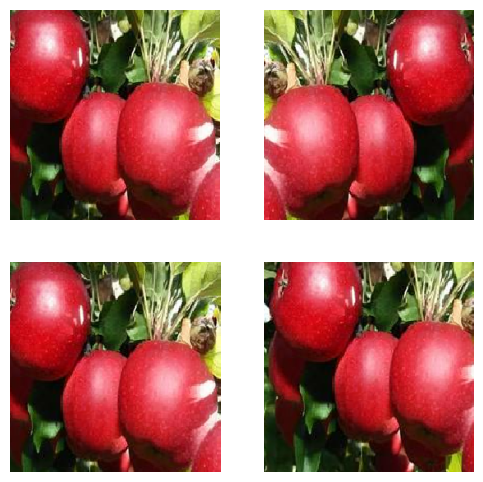

In [17]:
print('Apple')
plt.figure(figsize = (6,6))
for i in range(4):
  A_jitter = random_jitter(sample_A[0])
  plt.subplot(2, 2, i + 1)
  #plt.imshow(sample_A[0] * 0.5 + 0.5)
  plt.imshow(A_jitter * 0.5 + 0.5)
  plt.axis('off')
plt.show()

Orange


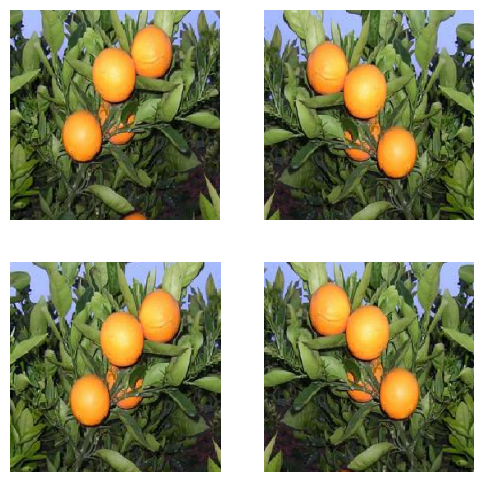

In [18]:
print('Orange')
plt.figure(figsize = (6,6))
for i in range(4):
  A_jitter = random_jitter(sample_B[0])
  plt.subplot(2, 2, i + 1)
  #plt.imshow(sample_B[0] * 0.5 + 0.5)
  plt.imshow(A_jitter * 0.5 + 0.5)
  plt.axis('off')
plt.show()

In [19]:
from examples.tensorflow_examples.models.pix2pix import pix2pix

In [20]:
output_channels = 3
generator_g = pix2pix.unet_generator(output_channels, norm_type = 'instancenorm')
generator_f = pix2pix.unet_generator(output_channels, norm_type = 'instancenorm')
discriminator_x = pix2pix.discriminator(norm_type = 'instancenorm', target = False)
discriminator_y = pix2pix.discriminator(norm_type = 'instancenorm', target = False)

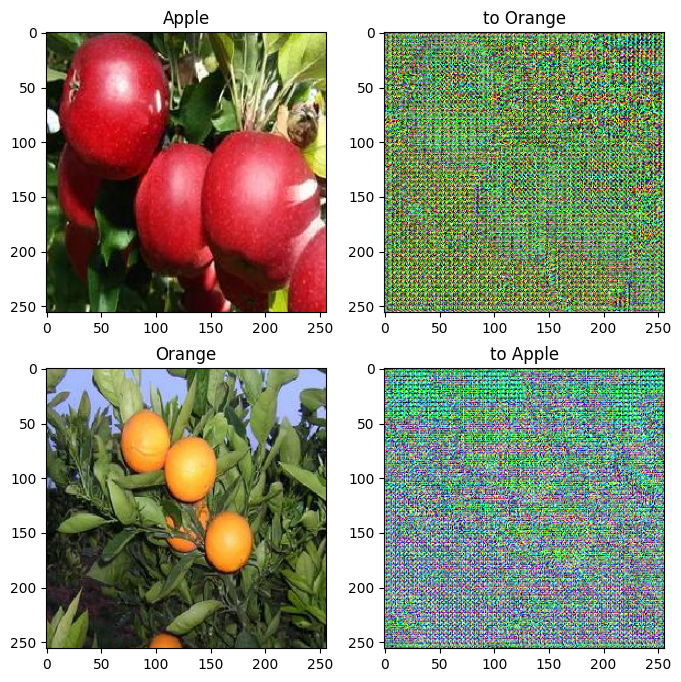

In [21]:
B_generated = generator_g(sample_A) # apple -> orange
A_generated = generator_f(sample_B) # orange -> apple
plt.figure(figsize = (8,8))
imgs = [sample_A, B_generated, sample_B, A_generated]
title = ['Apple', 'to Orange', 'Orange', 'to Apple']
for i in range(len(imgs)):
  plt.subplot(2, 2, i + 1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * 6 + 0.5)
plt.show()

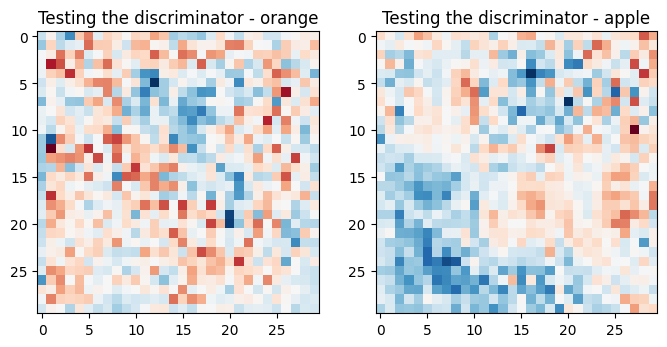

In [22]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.title('Testing the discriminator - orange')
plt.imshow(discriminator_y(sample_B)[0, ..., -1], cmap = 'RdBu_r')

plt.subplot(1, 2, 2)
plt.title('Testing the discriminator - apple')
plt.imshow(discriminator_x(sample_A)[0, ..., -1], cmap = 'RdBu_r')

plt.show()

In [23]:
lambda_ = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [24]:
def discriminator_loss(real, generated):
  real_loss = loss(tf.ones_like(real), real)
  generated_loss = loss(tf.zeros_like(generated), generated)
  d_total_loss = real_loss + generated_loss
  return d_total_loss

In [25]:
def generator_loss(generated):
  return loss(tf.ones_like(generated), generated)

In [26]:
def cycle_loss(real_img, cycled_img):
  loss1 = tf.reduce_mean(tf.abs(real_img - cycled_img)) # MAE
  return lambda_ * loss1

In [27]:
def identity_loss(real_img, equal_img):
  loss = tf.reduce_mean(tf.abs(real_img - equal_img))
  return lambda_ * 0.5 * loss

In [28]:
lr = 0.0002
beta1, beta2 = 0.5, 0.999

In [29]:
optimizer_generator_g = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
optimizer_generator_f = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

optimizer_discriminator_x = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
optimizer_discriminator_y = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

In [30]:
checkpoint_dir = "./checkpoints/train"
checkpoint = tf.train.Checkpoint(generator_g = generator_g,
                                 generator_f = generator_f,
                                 discriminator_x = discriminator_x,
                                 discriminator_y = discriminator_y,
                                 generator_g_optimizer=optimizer_generator_g,
                                 generator_f_optimizer = optimizer_generator_f,
                                 discriminator_x_optimizer = optimizer_discriminator_x,
                                 discriminator_y_optimizer = optimizer_discriminator_y)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep = 5)
if checkpoint_manager.latest_checkpoint:
  checkpoint.restore(checkpoint_manager.latest_checkpoing)
  print('Latest checkpoint restored!')

In [31]:
epochs = 10
def generate_images(model, test_input):
  generated = model(test_input)
  plt.figure(figsize = (8,6))
  list_imgs = [test_input[0], generated[0]]
  title = ['Original', 'Output (generated)']
  for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(title[i])
    plt.imshow(list_imgs[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [32]:
@tf.function
def training_step(real_x, real_y): # apple, orange
  with tf.GradientTape(persistent=True) as tape:
    # Generator G: X -> Y
    # Generator F: Y -> X

    # Apple into an orange fake
    fake_y = generator_g(real_x, training = True)
    # Cycle (apple into orange, orange into apple fake) x -> y -> x
    cycled_x = generator_f(fake_y, training = True)

    # Orange into an apple fake
    fake_x = generator_f(real_y, training = True)
    # Cycle (orange into apple fake, apple into orange fake) y -> x -> y
    cycled_y = generator_g(fake_x, training = True)

    # Identity mapping
    equal_x = generator_f(real_x, training = True)
    equal_y = generator_g(real_y, training = True)

    # Discriminator outputs
    discriminator_real_x = discriminator_x(real_x, training = True)
    discriminator_fake_x = discriminator_x(fake_x, training = True)
    discriminator_real_y = discriminator_y(real_y, training = True)
    discriminator_fake_y = discriminator_y(fake_y, training = True)

    # Loss calculation
    generator_g_loss = generator_loss(discriminator_fake_y)
    generator_f_loss = generator_loss(discriminator_fake_x)
    cycle_loss_total = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)
    total_generator_g_loss = generator_g_loss + cycle_loss_total + identity_loss(real_y, equal_y)
    total_generator_f_loss = generator_f_loss + cycle_loss_total + identity_loss(real_x, equal_x)
    discriminator_x_loss = discriminator_loss(discriminator_real_x, discriminator_fake_x)
    discriminator_y_loss = discriminator_loss(discriminator_real_y, discriminator_fake_y)

  # Gradients
  generator_g_gradients = tape.gradient(total_generator_g_loss, generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_generator_f_loss, generator_f.trainable_variables)
  discriminator_x_gradients = tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)

  # Optimizer
  optimizer_generator_g.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
  optimizer_generator_f.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
  optimizer_discriminator_x.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
  optimizer_discriminator_y.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [33]:
def train(training_A, training_B, generator_g, steps):
  for epoch in range(epochs):
    start = time.time()

    n = 0
    for img_x, img_y in tf.data.Dataset.zip((training_A, training_B)):
      training_step(img_x, img_y)
      if n % 10 == 0:
        print('.', end = '')
      n += 1

    clear_output(wait = True)
    generate_images(generator_g, sample_A)
    print('Time taken to train epoch {}: {} seconds\n'.format(epoch + 1, time.time() - start))

    if (epoch + 1) % 5 == 0:
      checkpoint_dir_saved = checkpoint_manager.save()
      print('Checkpoint saved')

    generator_g.save_weights('model_cyclegan.h5')

In [34]:
train(training_A, training_B, generator_g, epochs)

...................................................................................................

KeyboardInterrupt: ignored

In [ ]:
checkpoint.restore(tf.train.latest_checkpoing(checkpoint_dir))

In [ ]:
for input in testing_A.take(5):
  generate_images(generator_g, input)